In [32]:
import os
import os.path as osp
import pandas as pd
import matplotlib.pyplot as plt
import math

import airfrans as af

In [33]:
path_orig_sim = "/system/user/publicwork/setinek/scaling_laws/openfoam_sims_testbed/airFoil2D_SST_31.283_-4.156_0.919_6.98_14.32_local"
path_new_sim = "/system/user/publicwork/setinek/scaling_laws/openfoam_sims_testbed/airFoil2D_SST_31.283_-4.156_0.919_6.98_14.32_coarse_mesh_komegaSST_wallfcts2"

suffix = "postProcessing/forceCoeffs1/0/coefficient.dat"

In [34]:
def read_dat_file(path):
    # get column headers
    with open(path, 'r') as f:
        lines = f.readlines()
    for line in reversed(lines):
        if line.startswith('#') and 'Time' in line:
            col_line = line
            break
    colnames = col_line.strip('# \n').split('\t')
    colnames = [colname.strip() for colname in colnames]

    # read the data
    df = pd.read_csv(
        path,
        delim_whitespace=True,
        comment='#',
        header=None,
        names=colnames
    )
    return df

def read_log_files(log_dir):
    df_all = None

    for fname in os.listdir(log_dir):
        # skip foamLog.awk
        if fname == "foamLog.awk":
            continue

        fpath = os.path.join(log_dir, fname)
        try:
            with open(fpath, "r") as f:
                lines = f.readlines()
                # skip first line if it has only one column (e.g., a header like "1.22004e-09")
                if len(lines) > 1 and len(lines[0].split()) == 1:
                    lines = lines[1:]
                # convert to df
                data = [line.strip().split() for line in lines if len(line.strip().split()) == 2]
                # skip files with no valid rows
                if not data:
                    continue
                df = pd.DataFrame(data, columns=["Time", fname])
                df["Time"] = pd.to_numeric(df["Time"], errors="coerce")
                df[fname] = pd.to_numeric(df[fname], errors="coerce")
                df.dropna(inplace=True)

                if df_all is None:
                    df_all = df
                else:
                    df_all = pd.merge(df_all, df, on="Time", how="outer")
        except Exception as e:
            print(f"Skipping {fname}: {e}")

    df_all = df_all.sort_values("Time").reset_index(drop=True)
    return df_all


# def plot_log_columns(df, columns_to_plot, title=None, xlabel="Number of iterations", figsize_per_plot=(6, 3)):
#     """
#     Plots selected columns from a DataFrame in a 2-column grid with log-scaled y-axis.
    
#     Parameters:
#         df (pd.DataFrame): DataFrame containing 'Time' and value columns.
#         columns_to_plot (list of str): Column names to plot.
#         title (str): Optional super-title.
#         xlabel (str): Label for x-axis (shared).
#         figsize_per_plot (tuple): Size of each subplot.
#     """
#     if 'Time' not in df.columns:
#         raise ValueError("DataFrame must include a 'Time' column.")

#     n_cols = 2
#     n_plots = len(columns_to_plot)
#     n_rows = math.ceil(n_plots / n_cols)

#     fig, axs = plt.subplots(n_rows, n_cols, figsize=(figsize_per_plot[0] * n_cols, figsize_per_plot[1] * n_rows), sharex=True)
#     axs = axs.flatten()

#     for i, col in enumerate(columns_to_plot):
#         ax = axs[i]
#         if col in df.columns:
#             ax.plot(df['Time'], df[col])
#             ax.set_yscale('log')
#             ax.set_title(col)
#             ax.set_xlabel(xlabel)
#             ax.set_ylabel("Value")
#             ax.grid(True, which='both', linestyle='--', linewidth=0.5)

#             # Ensure x ticks and labels are shown on all plots
#             ax.tick_params(axis='x', labelbottom=True)
#             # ax.set_xticks(df['Time'][::max(1, len(df)//10)])  # reduce number of ticks
#             # ax.tick_params(axis='x', rotation=45)
#             ax.tick_params(axis='x')


#         else:
#             ax.text(0.5, 0.5, f"Column '{col}' not found", ha='center', va='center', transform=ax.transAxes)
#             ax.set_axis_off()

#     # Hide any extra axes
#     for j in range(n_plots, len(axs)):
#         axs[j].set_visible(False)

#     if title:
#         fig.suptitle(title, fontsize=16)
#         plt.subplots_adjust(top=0.93)

#     plt.tight_layout()
#     plt.show()


def plot_log_columns(dfs_dict, columns_to_plot, title=None,
                     xlabel="Number of iterations", figsize_per_plot=(6, 3)):
    linestyles = ["-", "--"]
    # sanity check: every df must have a 'Time'
    for name, df in dfs_dict.items():
        if 'Time' not in df.columns:
            raise ValueError(f"DataFrame for '{name}' must include a 'Time' column.")

    n_cols = 2
    n_plots = len(columns_to_plot)
    n_rows = math.ceil(n_plots / n_cols)

    fig, axs = plt.subplots(
        n_rows, n_cols,
        figsize=(figsize_per_plot[0] * n_cols,
                 figsize_per_plot[1] * n_rows),
        sharex=True
    )
    axs = axs.flatten()

    for i, col in enumerate(columns_to_plot):
        ax = axs[i]
        # plot each DataFrame
        for i, (label, df) in enumerate(dfs_dict.items()):
            if col in df.columns:
                ax.plot(df['Time'], df[col], label=label, linestyle=linestyles[i])
        ax.set_yscale('log')
        ax.set_title(col)
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Value")
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.legend()
        # ensure x-ticks show on all
        ax.tick_params(axis='x', labelbottom=True, rotation=45)

    # hide any unused subplots
    for j in range(n_plots, len(axs)):
        axs[j].set_visible(False)

    if title:
        fig.suptitle(title, fontsize=16)
        plt.subplots_adjust(top=0.93)

    plt.tight_layout()
    plt.show()

In [35]:
import os.path as osp
import pandas as pd
import matplotlib.pyplot as plt

ref_path = osp.join(path_orig_sim, suffix)
test_path = osp.join(path_new_sim, suffix)

ref = read_dat_file(ref_path)
test = read_dat_file(test_path)

In [36]:
ref[ref["Time"] == 20000]

,Time,Cd,Cd(f),Cd(r),Cl,Cl(f),Cl(r),CmPitch,CmRoll,CmYaw,Cs,Cs(f),Cs(r)
1999,20000,0.010675,0.165841,-0.155165,-0.321006,-0.117333,-0.203673,0.04317,0.160503,0.005338,-1.772559e-22,0.005338,-0.005338


In [37]:
test[test["Time"] == 20000]

,Time,Cd,Cd(f),Cd(r),Cl,Cl(f),Cl(r),CmPitch,CmRoll,CmYaw,Cs,Cs(f),Cs(r)
1999,20000,0.010708,0.166099,-0.155391,-0.321491,-0.117515,-0.203976,0.04323,0.160745,0.005354,-5.064408e-23,0.005354,-0.005354


/tmp/ipykernel_1492211/457160425.py:138: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


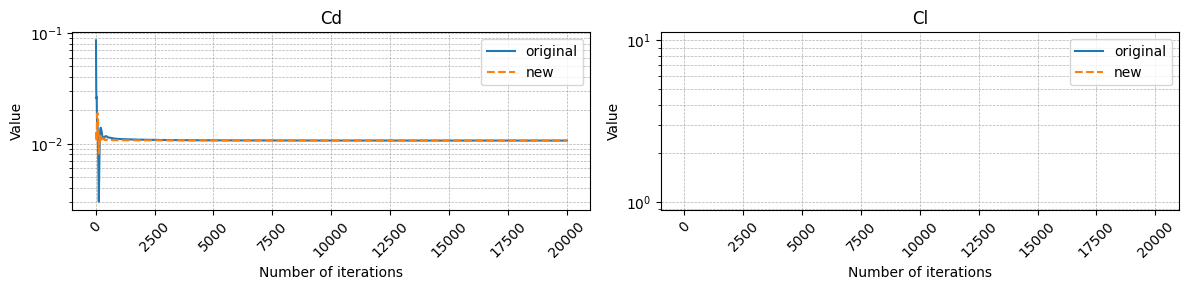

In [38]:
plot_log_columns(dfs_dict={"original": ref, "new":test}, columns_to_plot=["Cd", "Cl"])

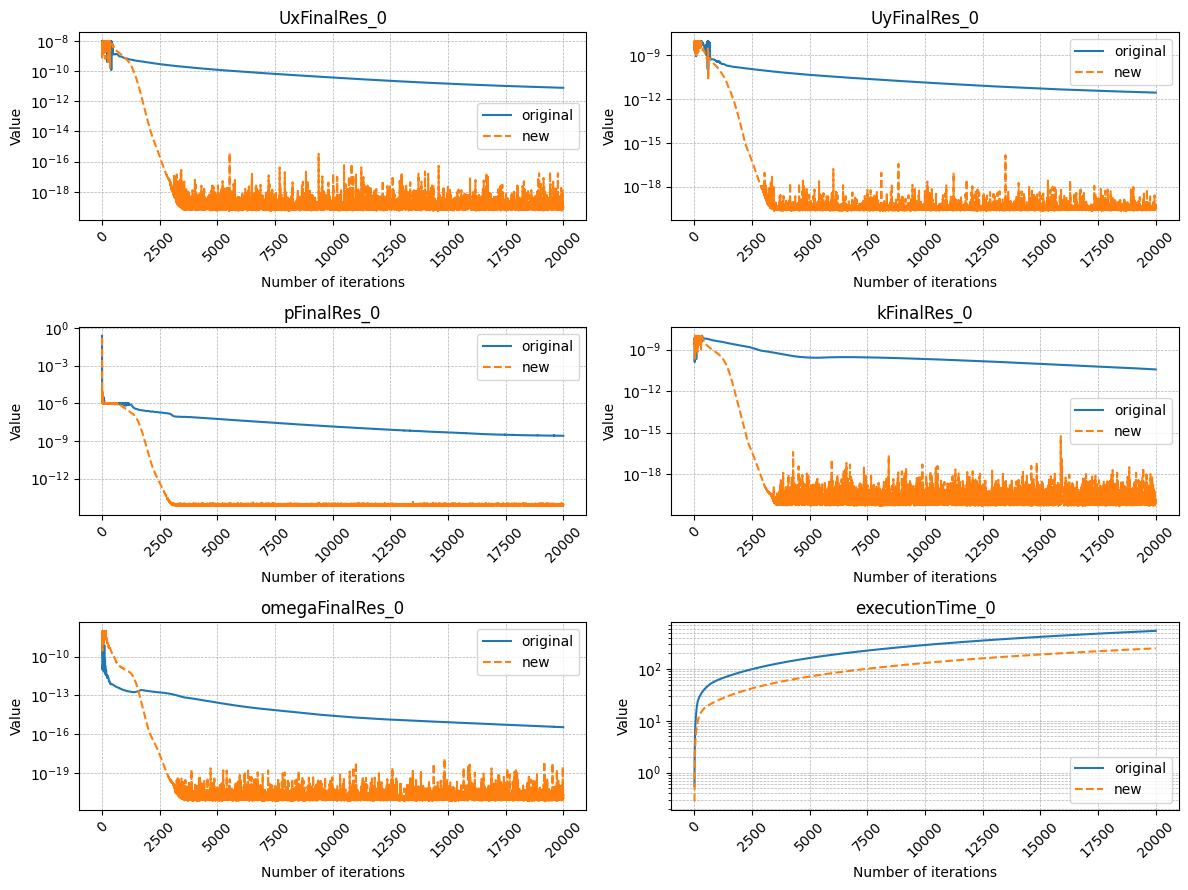

In [39]:
log_df_original = read_log_files(osp.join(path_orig_sim, "logs"))
log_df_new = read_log_files(osp.join(path_new_sim, "logs"))

# plot_log_columns(df=log_df_original, columns_to_plot=["UxFinalRes_0", "UyFinalRes_0", "pFinalRes_0", "kFinalRes_0", "omegaFinalRes_0", "executionTime_0"])
plot_log_columns(dfs_dict={"original": log_df_original, "new":log_df_new}, columns_to_plot=["UxFinalRes_0", "UyFinalRes_0", "pFinalRes_0", "kFinalRes_0", "omegaFinalRes_0", "executionTime_0"])

In [30]:
log_df_original

,Time,contCumulative_0,p_3,kAvg_0,pIters_1,contGlobal_0,kIters_0,pFinalRes_0,pIters_2,omegaIters_0,...,p_1,UyIters_0,omegaFinalRes_0,clockTime_0,k_0,Separator_0,pFinalRes_2,Uy_0,UxIters_0,omega_0
0,1,1.245550e-06,1.009060e-05,1.816700e-09,300,1.245550e-06,7,2.368140e-01,300,5,...,7.034370e-05,12,6.391640e-09,6,1.000000e+00,1,2.850840e-06,1.000000e+00,11,2.004400e-03
1,2,-3.062310e-07,9.988560e-05,1.790750e-09,300,-1.551780e-06,5,9.684390e-06,300,3,...,4.073980e-04,7,2.295060e-10,6,4.450100e-02,2,2.050250e-05,9.329850e-03,6,1.616520e-02
2,3,-4.368510e-07,5.467490e-05,4.273280e-09,300,-1.306190e-07,5,9.899080e-06,300,3,...,2.407120e-04,7,7.227880e-10,6,2.433210e-01,3,1.232760e-05,2.403800e-03,5,8.887040e-04
3,4,-2.984170e-07,3.876160e-05,2.713090e-08,300,1.384330e-07,4,2.833800e-05,300,3,...,1.510430e-04,6,4.927770e-10,7,3.222880e-01,4,1.240570e-05,1.792050e-03,5,6.993040e-04
4,5,-2.550980e-07,1.606530e-05,2.090250e-07,300,4.331890e-08,3,1.014880e-05,300,3,...,7.490560e-05,7,3.880330e-10,7,3.183090e-01,5,3.825530e-06,1.698460e-03,5,3.182940e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19996,-2.389940e-06,2.831300e-09,8.264890e-01,10,9.407390e-12,3,2.592420e-09,10,3,...,3.244980e-09,3,3.455810e-16,583,7.204050e-08,19996,2.262960e-09,6.467640e-09,3,9.168430e-13
19996,19997,-2.389930e-06,2.833390e-09,8.264900e-01,10,9.405680e-12,3,2.600810e-09,10,3,...,3.250710e-09,3,3.455320e-16,583,7.202990e-08,19997,2.266910e-09,6.467230e-09,3,9.168410e-13
19997,19998,-2.389930e-06,2.831000e-09,8.264900e-01,10,9.406690e-12,3,2.592280e-09,10,3,...,3.244330e-09,3,3.454620e-16,583,7.201940e-08,19998,2.262920e-09,6.466770e-09,3,9.165440e-13
19998,19999,-2.389920e-06,2.833560e-09,8.264900e-01,10,9.406330e-12,3,2.600890e-09,10,3,...,3.250460e-09,3,3.454130e-16,583,7.200880e-08,19999,2.267090e-09,6.466350e-09,3,9.165410e-13


In [31]:
log_df_new

,Time,contCumulative_0,p_3,kAvg_0,pIters_1,contGlobal_0,kIters_0,pFinalRes_0,pIters_2,omegaIters_0,...,p_1,UyIters_0,omegaFinalRes_0,clockTime_0,k_0,Separator_0,pFinalRes_2,Uy_0,UxIters_0,omega_0
0,1,5.174020e-07,2.663770e-05,NaN,300,5.174020e-07,9,9.694160e-02,300,9,...,3.009820e-04,16,2.996360e-10,0,1.000000e+00,1,4.905130e-06,1.000000e+00,17,1.807260e-05
1,2,-9.272640e-08,1.682170e-04,NaN,300,-6.101280e-07,6,3.992530e-05,300,7,...,1.955110e-03,7,8.890270e-09,0,4.687980e-02,2,3.369180e-05,2.072350e-02,6,3.945110e-04
2,3,1.573520e-08,7.971430e-05,NaN,300,1.084620e-07,6,3.145730e-05,300,5,...,5.473150e-04,8,9.048270e-09,0,1.040950e-02,3,1.425550e-05,7.650850e-03,7,1.221230e-03
3,4,4.516630e-08,3.025560e-05,NaN,300,2.943100e-08,5,3.152500e-05,300,5,...,2.960670e-04,6,7.092220e-09,0,4.114980e-03,4,5.125000e-06,6.130500e-03,6,7.910100e-04
4,5,7.500350e-08,1.140430e-05,NaN,285,2.983730e-08,4,4.336470e-06,228,5,...,1.664520e-04,6,7.829000e-09,1,3.175290e-03,5,9.592020e-07,5.511040e-03,6,5.151310e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19996,8.779140e-07,7.573720e-15,NaN,10,6.074440e-18,3,7.232980e-15,10,3,...,1.358620e-14,3,1.218140e-21,278,1.787730e-17,19996,2.043070e-15,4.481320e-15,3,8.089680e-18
19996,19997,8.779140e-07,7.692220e-15,NaN,10,2.472750e-18,3,6.830610e-15,10,3,...,1.323860e-14,3,1.141720e-21,278,1.740330e-17,19997,2.251850e-15,4.495730e-15,3,7.956120e-18
19997,19998,8.779140e-07,7.419270e-15,NaN,10,-9.161170e-19,3,7.162320e-15,10,3,...,1.351860e-14,3,1.273470e-21,278,1.867180e-17,19998,1.864170e-15,4.432230e-15,3,8.532260e-18
19998,19999,8.779140e-07,7.432940e-15,NaN,10,-9.470180e-18,3,6.603260e-15,10,3,...,1.289410e-14,3,1.288160e-21,278,1.794630e-17,19999,1.948610e-15,4.473280e-15,3,8.256180e-18
